In [1]:
import cooler
import numpy as np
import bioframe


import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def _zero_diags(chunk, n_diags):
    if n_diags > 0:
        mask = np.abs(chunk['pixels']['bin1_id'] - chunk['pixels']['bin2_id']) < n_diags
        chunk['pixels']['count'][mask] = 0    
    return chunk

def _zero_range(chunk, range_bins):
    mask = np.abs(chunk['pixels']['bin1_id'] - chunk['pixels']['bin2_id']) >= range_bins
    chunk['pixels']['count'][mask] = 0    
    return chunk



def _timesouterproduct(chunk, bias):
    pixels = chunk["pixels"]
    data = bias[pixels["bin1_id"]] * bias[pixels["bin2_id"]] * pixels["count"]
    chunk['pixels']['balanced'] = data
    # returning modified chinks with an additional column:
    return chunk



# def _zero_diags(n_diags, chunk, data):
#     pixels = chunk["pixels"]
#     mask = np.abs(pixels["bin1_id"] - pixels["bin2_id"]) < n_diags
#     data[mask] = 0
#     return data

# def _zero_trans(chunk, data):
#     chrom_ids = chunk["bins"]["chrom"]
#     pixels = chunk["pixels"]
#     mask = chrom_ids[pixels["bin1_id"]] != chrom_ids[pixels["bin2_id"]]
#     data[mask] = 0
#     return data

# def _zero_cis(chunk, data):
#     chrom_ids = chunk["bins"]["chrom"]
#     pixels = chunk["pixels"]
#     mask = chrom_ids[pixels["bin1_id"]] == chrom_ids[pixels["bin2_id"]]
#     data[mask] = 0
#     return data

# def _timesouterproduct(vec, chunk, data):
#     pixels = chunk["pixels"]
#     data = vec[pixels["bin1_id"]] * vec[pixels["bin2_id"]] * data
#     return data




def _get_chunk_coverage_tot(chunk, pixel_weight_key='count'):
    '''
    Compute total coverages of a cooler chunk.
    
    Parameters
    ----------
    chunk : dict of dict/pd.DataFrame
        A cooler chunk produced by the cooler split-apply-combine pipeline.
    pixel_weight_key: str
        The key of a pixel chunk to retrieve pixel weights.
    
    Returns
    -------
    covs : np.array n_bins    
        A numpy array with the total coverages.
    '''
    
    bins = chunk['bins']
    pixels = chunk['pixels']
    n_bins = len(bins['chrom'])
    covs = np.zeros(n_bins)
    pixel_weights = pixels[pixel_weight_key]
        
    covs += np.bincount(pixels['bin1_id'], weights=pixel_weights, minlength=n_bins)
    covs += np.bincount(pixels['bin2_id'], weights=pixel_weights, minlength=n_bins)
    
    covs = covs / 2
    
    return covs





def _get_chunk_coverage_cis(chunk, pixel_weight_key='count'):
    '''
    Compute cis coverages of a cooler chunk.
    
    Parameters
    ----------
    chunk : dict of dict/pd.DataFrame
        A cooler chunk produced by the cooler split-apply-combine pipeline.
    pixel_weight_key: str
        The key of a pixel chunk to retrieve pixel weights.
    
    Returns
    -------
    covs : np.array n_bins    
        A numpy array with the cis coverages.
    '''
    
    bins = chunk['bins']
    pixels = chunk['pixels']
    n_bins = len(bins['chrom'])
    covs = np.zeros(n_bins)
    pixel_weights = pixels[pixel_weight_key]
    
    cis_mask = bins['chrom'][pixels['bin1_id']] == bins['chrom'][pixels['bin2_id']]
    covs += np.bincount(pixels['bin1_id'], weights=pixel_weights*cis_mask, minlength=n_bins)
    covs += np.bincount(pixels['bin2_id'], weights=pixel_weights*cis_mask, minlength=n_bins)
    
    covs = covs / 2
    
    return covs


In [3]:
# path = 'ZT-KO-STAG2.hg19.mapq_30.1000.mcool::/resolutions/50000'
path = '/home/venevs/houda_test/HBHiC-K562-MN-Dp-2.40000.cool'
# path = '/home/venevs/houda_test/pairs/validpairs.cool'
path = '/home/venevs/houda_test/HBHiCK562DN10-4hDp2.40000.cool'
path = '/home/venevs/houda_test/pair_4h/4h_valids.cool'

In [4]:
vvv = bioframe.read_table(
    '/home/venevs/houda_test/HBHiC-K562-MN-DpnII-R1-filter1000__hg19__genome__C-40000-iced_scaleBy_0.41_range6Mb_cispercent.bedGraph')
vvv = bioframe.read_table(
    '/home/venevs/houda_test/HBHiCK562DN10-4h-DpnII-R1-filter1000__hg19__genome__C-40000-iced_scaleBy_0.41_range6Mb_cispercent.bedGraph')


hhh = np.nan_to_num(vvv[3].values)

In [5]:
c = cooler.Cooler(path)

In [6]:
aaaa = c.matrix()[:]

In [7]:
aaaa.shape

(77404, 77404)

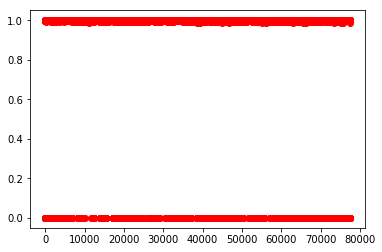

In [8]:
plt.plot([np.nansum(aaaa[:,i]) for i in range(77404)],'ro')

In [9]:
r = 6000000
p = 0.1

# bin_positions = h['bin_positions'][:]
bin_positions = c.bins()[:]['chrom'].values
cp_list = []
resolution =  c.info['bin-size']
max_NAs = (r/resolution) * p
dist = int((r/resolution)/2)
obs = aaaa
num_bins = len(obs)
for i, row in enumerate(obs):
    # Check if row is all nan
    if np.all(np.isnan(row)) or np.nansum(row) == 0:
        cp_list.append(np.nan)
    # Check if at start of genome
    elif i - dist < 0:
        cp_list.append(np.nan)
    # Check if at end of genome
    elif i + (dist- 1) > num_bins -1:
        cp_list.append(np.nan)
    # Check if at start of chromosome (upstream range reaches trans)
    elif bin_positions[i] != bin_positions[i-dist]:
        cp_list.append(np.nan)
    # Check if at end of chromosome (downstream range reaches trans) 
    elif bin_positions[i] != bin_positions[i+(dist-1)]:
            cp_list.append(np.nan)
    else:
        # Check if too many NAs in range window
        if np.sum(np.isnan(row[i-dist:i+dist])) > max_NAs:
            cp_list.append(np.nan)
        else:
            cis = np.nansum(row[i-dist:i+dist])
            total = np.nansum(row)
            cp = (cis/total) * 100
            cp_list.append(cp)


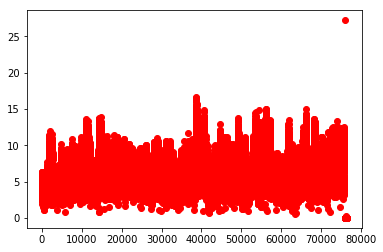

In [10]:
plt.plot(cp_list,'ro')

In [11]:
ignore_diags = 0
binsize = c.info['bin-size']
n_bins = c.info['nbins']
bias = np.nan_to_num(c.bins()[:]['weight'].values)
grange = 3000000
range_bins=int(grange/binsize)

# split apply combine ...
chunks = cooler.tools.split(c, chunksize=int(1e7), map=map, use_lock=False)
chunks = chunks.pipe(_zero_diags, n_diags=ignore_diags)
chunks = chunks.pipe(_zero_range, range_bins=range_bins)

covs = (
    chunks
        .pipe(_timesouterproduct, bias=bias)
        .pipe(_get_chunk_coverage_cis, pixel_weight_key="balanced")
        .reduce( np.add, np.zeros(n_bins) )
)


In [16]:
# range_bins=range_bins
binsize = c.info['bin-size']
n_bins = c.info['nbins']
grange = 3000000
range_bins=int(grange/binsize)

c.chromnames
[(chr1,c.offset(chr1)+range_bins,c.offset(chr2)-range_bins) for chr1,chr2 in zip(c.chromnames[:-2],c.chromnames[1:-1])]


ccc = np.concatenate([covs[c.offset(chr1)+range_bins:c.offset(chr2)-range_bins] for chr1,chr2 in zip(c.chromnames[:-2],c.chromnames[1:-1])])
# ccc = np.concatenate([cp_list[c.offset(chr1)+range_bins:c.offset(chr2)-range_bins] for chr1,chr2 in zip(c.chromnames[:-2],c.chromnames[1:-1])])


kkk = np.concatenate([hhh[c.offset(chr1)+range_bins:c.offset(chr2)-range_bins] for chr1,chr2 in zip(c.chromnames[:-2],c.chromnames[1:-1])])

(-100, 72568)

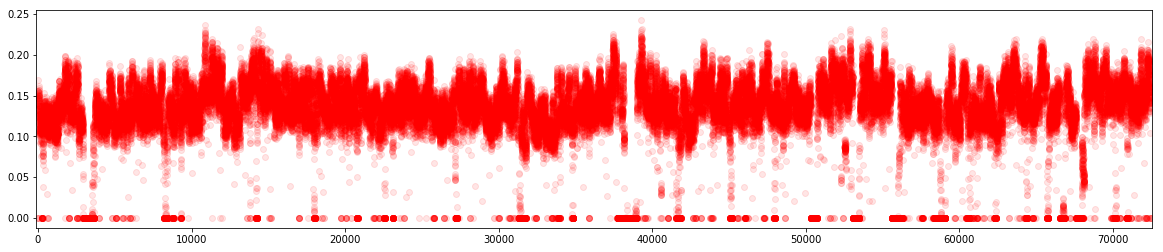

In [16]:
plt.plot(ccc,'ro',alpha=0.1)
fig = plt.gcf()
fig.set_size_inches((20,4))
ax = plt.gca()
ax.set_xlim(-100,ccc.size+100)
# plt.gca().set_ylim((0,0.8))

(-100, 72568)

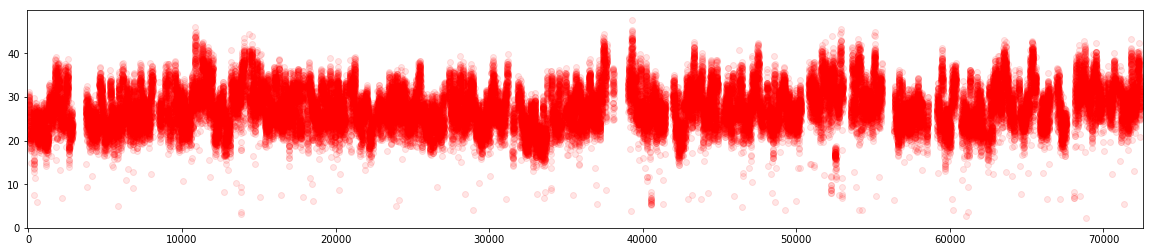

In [39]:
plt.plot(ccc,'ro',alpha=0.1)
fig = plt.gcf()
fig.set_size_inches((20,4))
ax = plt.gca()
ax.set_xlim(-100,ccc.size+100)
# plt.gca().set_ylim((0,0.8))

(-100, 72568)

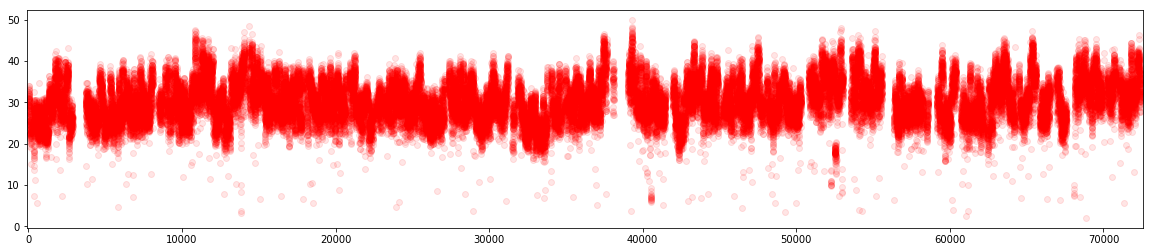

In [49]:
plt.plot(ccc,'ro',alpha=0.1)
fig = plt.gcf()
fig.set_size_inches((20,4))
ax = plt.gca()
ax.set_xlim(-100,ccc.size+100)
# plt.gca().set_ylim((0,0.8))

(-100, 72568)

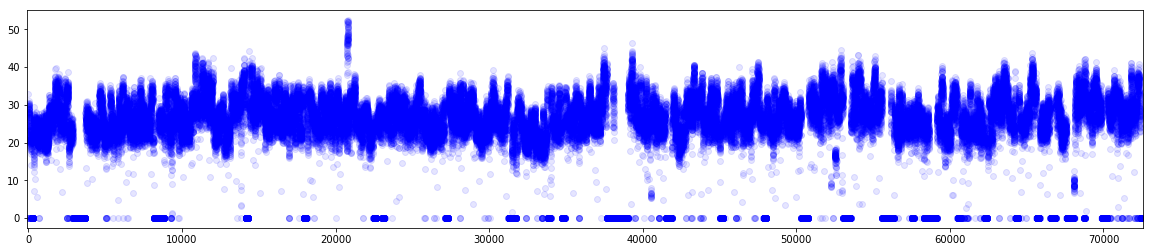

In [40]:
plt.plot(kkk,'bo',alpha=0.1)
fig = plt.gcf()
fig.set_size_inches((20,4))
ax = plt.gca()
ax.set_xlim(-100,kkk.size+100)
# plt.gca().set_ylim((0,0.8))

(-100, 72568)

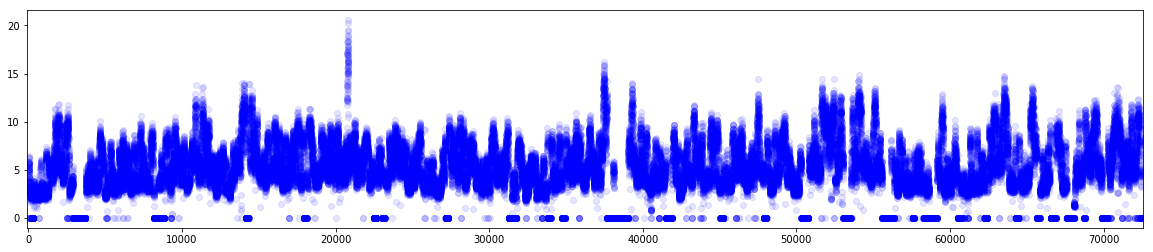

In [13]:
plt.plot(kkk,'bo',alpha=0.1)
fig = plt.gcf()
fig.set_size_inches((20,4))
ax = plt.gca()
ax.set_xlim(-100,kkk.size+100)
# plt.gca().set_ylim((0,0.8))

(-100, 72568)

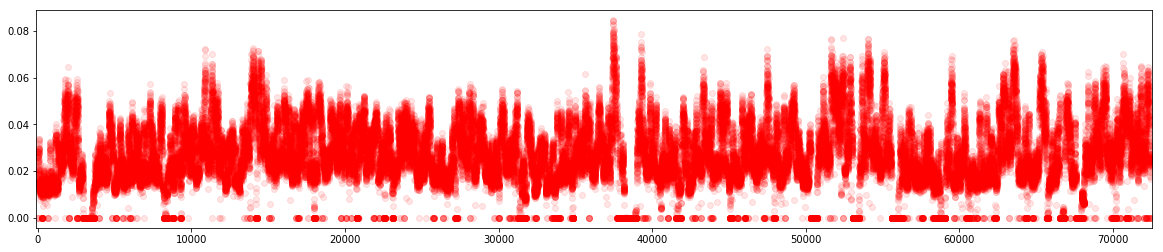

In [17]:
plt.plot(ccc,'ro',alpha=0.1)
fig = plt.gcf()
fig.set_size_inches((20,4))
ax = plt.gca()
ax.set_xlim(-100,ccc.size+100)
# plt.gca().set_ylim((0,0.8))

(-100, 72568)

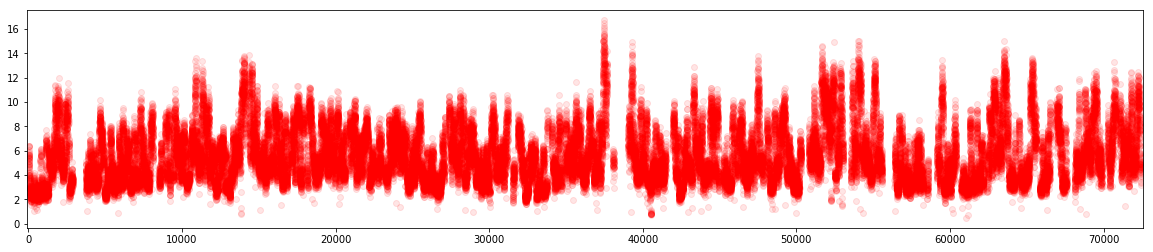

In [14]:
plt.plot(ccc,'ro',alpha=0.1)
fig = plt.gcf()
fig.set_size_inches((20,4))
ax = plt.gca()
ax.set_xlim(-100,ccc.size+100)
# plt.gca().set_ylim((0,0.8))

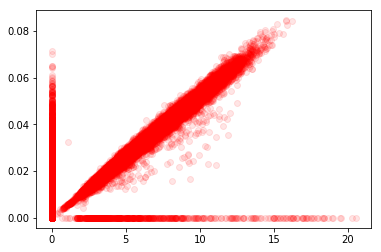

In [18]:
# vvv.head()

hhh = np.nan_to_num(vvv[3].values)

plt.plot(kkk,ccc,'ro',alpha=0.1)

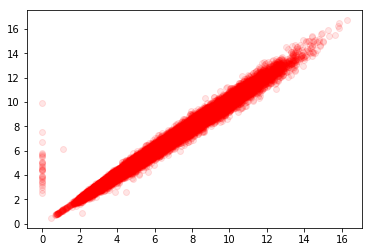

In [15]:
# vvv.head()

hhh = np.nan_to_num(vvv[3].values)

plt.plot(kkk,ccc,'ro',alpha=0.1)

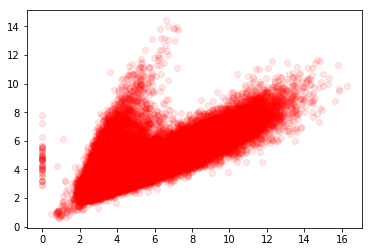

In [16]:
# vvv.head()

hhh = np.nan_to_num(vvv[3].values)

plt.plot(kkk,ccc,'ro',alpha=0.1)

In [229]:
!ls /home/venevs/houda_test




HBHiCK562DN10-4hDp2.40000.cool
HBHiCK562DN10-4h-DpnII-R1-filter1000__hg19__genome__C-40000-iced_scaleBy_0.41_range6Mb_cispercent.bedGraph
HBHiC-K562-MN-Dp-2.40000.cool
HBHiC-K562-MN-DpnII-R1-filter1000__hg19__genome__C-40000-iced_scaleBy_0.41_range6Mb_cispercent.bedGraph


In [16]:
xxx[:]['count'].sum()

781480732

In [22]:
vvv= xxx[8000:9000]

In [35]:
c.bins()[:]

,chrom,start,end,weight
0,chr1,0,100000,NaN
1,chr1,100000,200000,NaN
2,chr1,200000,300000,NaN
3,chr1,300000,400000,NaN
4,chr1,400000,500000,NaN
5,chr1,500000,600000,NaN
6,chr1,600000,700000,NaN
7,chr1,700000,800000,NaN
8,chr1,800000,900000,0.003324
9,chr1,900000,1000000,0.002763


In [1]:
import pandas as pd

In [1]:
pd.read_csv?

Object `pd.read_csv` not found.


In [284]:
# p1 = pd.read_csv(
#     '/home/venevs/houda_test/pairs/17FEB17_AHHNTJBB_C-Monster__HBHiC-K562-MN-Dp-2-filter1000__hg19.validPair.txt.gz',
#     sep='\t',header=None)

p3 = pd.read_csv(
    '/home/venevs/houda_test/pairs/20JAN17_C-Monster-A-HHHJWBB_HB__HBHiC-K562-MN-Dp-2-filter1000__hg19.validPair.txt.gz',
    sep='\t',header=None,chunksize=1e5)

In [285]:
p2.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,U,chr1,10227,+,K00284:53:HHHJWBBXX:8:2224:22181:20375,0,U,chr18,78007970,-,K00284:53:HHHJWBBXX:8:2224:22181:20375,6188659
1,U,chr1,10239,+,K00284:53:HHHJWBBXX:8:2206:26007:10581,0,U,chr19,12073191,+,K00284:53:HHHJWBBXX:8:2206:26007:10581,6228280
2,U,chr1,10239,+,K00284:53:HHHJWBBXX:8:2206:26129:10616,0,U,chr19,12073191,+,K00284:53:HHHJWBBXX:8:2206:26129:10616,6228280
3,U,chr1,10239,+,K00284:53:HHHJWBBXX:8:2206:26220:10739,0,U,chr19,12073191,+,K00284:53:HHHJWBBXX:8:2206:26220:10739,6228280
4,U,chr1,10239,+,K00284:53:HHHJWBBXX:8:2206:26332:11108,0,U,chr19,12073191,+,K00284:53:HHHJWBBXX:8:2206:26332:11108,6228280


In [3]:
# p3 = pd.read_csv(
#     '/home/venevs/houda_test/pairs/20JAN17_C-Monster-A-HHHJWBB_HB__HBHiC-K562-MN-Dp-2-filter1000__hg19.validPair.txt.gz',
#     sep='\t',header=None,chunksize=1e7)

p3 = pd.read_csv(
    '/home/venevs/houda_test/pairs/17FEB17_AHHNTJBB_C-Monster__HBHiC-K562-MN-Dp-2-filter1000__hg19.validPair.txt.gz',
    sep='\t',header=None,chunksize=1e7)

outp = "/home/venevs/houda_test/pairs/17FEBout.pairs.gz"
for p in p3:
    p['type'] = p[0]+p[6]
    p[[4,1,2,7,8,3,9,'type']].to_csv(outp,mode='a',sep='\t',header=False,index=False,compression='gzip')

In [290]:
# sanity ...
# (p2[0]+p2[6]).unique()
# (p2[4]==p2[10]).all()

p2['type'] = p2[0]+p2[6]
p2[[4,1,2,7,8,3,9,'type']].head().to_csv(sep='\t',)

,4,1,2,7,8,3,9,type
0,K00284:53:HHHJWBBXX:8:2224:22181:20375,chr1,10227,chr18,78007970,+,-,UU
1,K00284:53:HHHJWBBXX:8:2206:26007:10581,chr1,10239,chr19,12073191,+,+,UU
2,K00284:53:HHHJWBBXX:8:2206:26129:10616,chr1,10239,chr19,12073191,+,+,UU
3,K00284:53:HHHJWBBXX:8:2206:26220:10739,chr1,10239,chr19,12073191,+,+,UU
4,K00284:53:HHHJWBBXX:8:2206:26332:11108,chr1,10239,chr19,12073191,+,+,UU


In [293]:
p2.to_csv('',header=False,index=False,compression=None)

In [294]:
p2.to_csv?